# L2-A - Linear Quantization I: Quantize and De-quantize a Tensor

## Quantization with Random `Scale` and `Zero Point`

- Implement Linear Quantization for when the "scale" and the "zero point" are known/randomly selected.

In [2]:
import torch

In [3]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=torch.int8):
    scaled_and_shifted_tensor = tensor/scale + zero_point # r = s(q - z) -> q = r/s + z

    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)

    return q_tensor

In [4]:
### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [5]:
# random values for scale and zero point
scale = 3.2
zero_point = -50

In [6]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
quantized_tensor

tensor([[  10,  -54,  127],
        [ -21,   42, -108],
        [ -50,  127,   27]], dtype=torch.int8)

## Dequantization with Random `Scale` and `Zero Point`
- Now, Dequantize the tensor to see how precise the quantization is.

In [7]:
dequantized_tensor = scale*(quantized_tensor.float() - zero_point)
dequantized_tensor
# original tensor
# [[191.6, -13.5, 728.6],
#  [92.14, 295.5,  -184],
#  [0,     684.6, 245.5]]

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

In [8]:
# without casting to float
dequantized_tensor = scale*(quantized_tensor - zero_point)
dequantized_tensor # some values are different due to overflow or underflow

tensor([[ 192.0000,  -12.8000, -252.8000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000, -252.8000,  246.4000]])

In [9]:
def linear_dequantization(tensor, scale, zero_point):
    return scale*(tensor.float() - zero_point)

In [10]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)
dequantized_tensor

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

### Quantization Error
- Load the `plot_quantization_errors` from the helper file.
- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [11]:
from helper import plot_quantization_errors

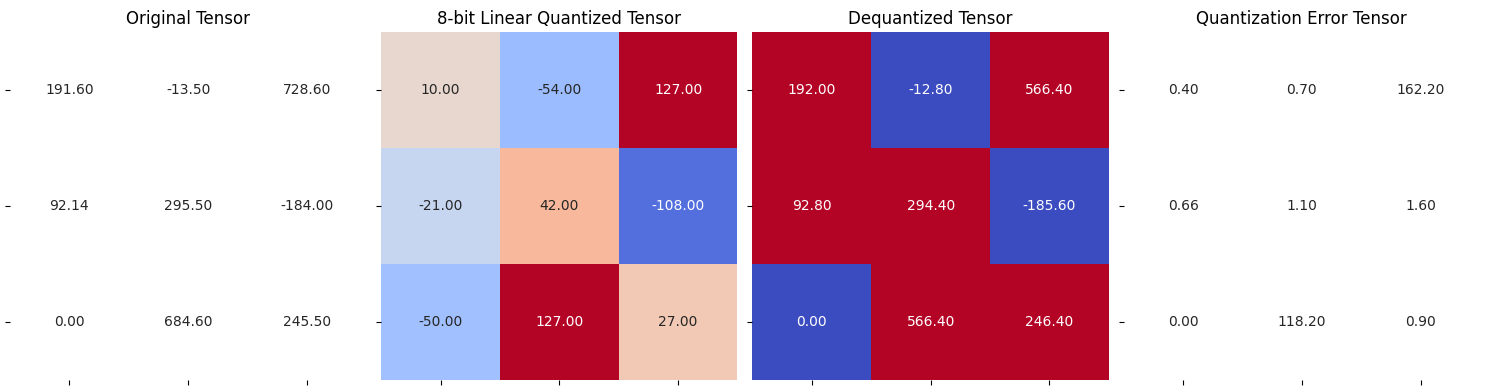

In [12]:
plot_quantization_errors(test_tensor, quantized_tensor,
                         dequantized_tensor)

**Note:** For the plot above, `Quantization Error Tensor = abs(Original Tensor - Dequantized Tensor)`

- Calculate an "overall" quantization error by using [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) technique.

In [13]:
dequantized_tensor - test_tensor

tensor([[   0.4000,    0.7000, -162.2000],
        [   0.6600,   -1.1000,   -1.6000],
        [   0.0000, -118.2000,    0.9000]])

In [14]:
(dequantized_tensor - test_tensor).square()

tensor([[1.6000e-01, 4.9000e-01, 2.6309e+04],
        [4.3560e-01, 1.2100e+00, 2.5600e+00],
        [0.0000e+00, 1.3971e+04, 8.1002e-01]])

In [15]:
(dequantized_tensor - test_tensor).square().mean()

tensor(4476.1909)

# L2-B - Linear Quantization I: Get the Scale and Zero Point

In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

## Finding `Scale` and `Zero Point` for Quantization

In [16]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max
q_min, q_max

(-128, 127)

In [17]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()
r_min, r_max

(-184.0, 728.5999755859375)

In [18]:
scale = (r_max - r_min) / (q_max - q_min)
scale

3.578823433670343

In [19]:
zero_point = q_min - (r_min / scale)
zero_point

-76.58645490333825

In [20]:
zero_point = int(round(zero_point))
zero_point

-77

Make it into a function

In [21]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = q_min - (r_min / scale)

    # clip the zero point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [22]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
new_scale, new_zero_point

(3.578823433670343, -77)

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [23]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [24]:
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

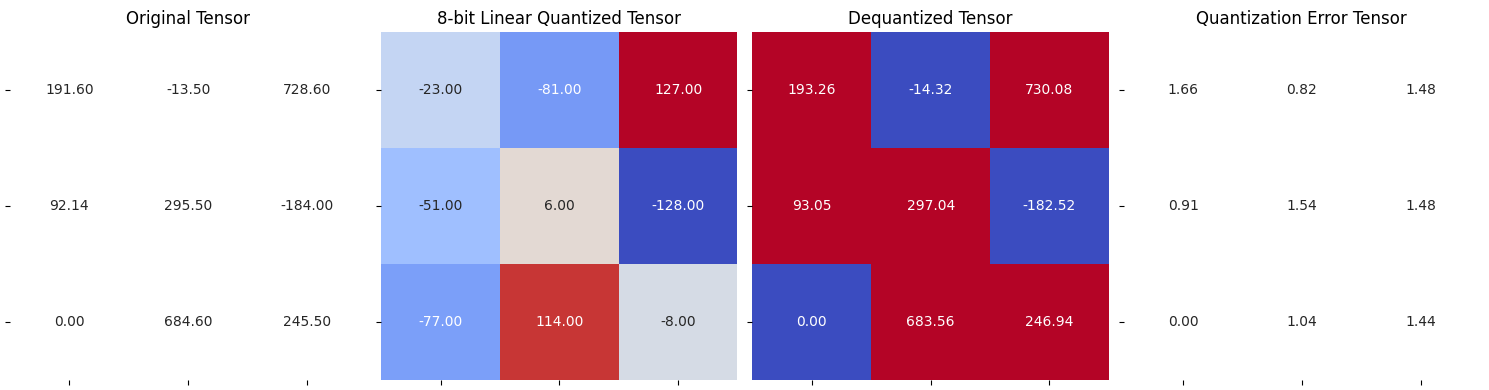

In [25]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [26]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [27]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point)

    return quantized_tensor, scale, zero_point

- Test implementation on a random matrix.

In [28]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[-1.0892, -0.1983, -0.8325,  0.2356],
        [ 1.1313, -1.1189, -1.2398,  0.3087],
        [ 0.1323,  1.5578, -1.6434,  0.7962],
        [-1.7292,  1.6728,  1.3803, -0.2175]])

In [29]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [30]:
quantized_tensor

tensor([[ -80,  -13,  -60,   20],
        [  87,  -82,  -91,   25],
        [  12,  119, -121,   62],
        [-128,  127,  105,  -14]], dtype=torch.int8)

In [31]:
scale

0.01334094627230775

In [32]:
zero_point

2

In [33]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

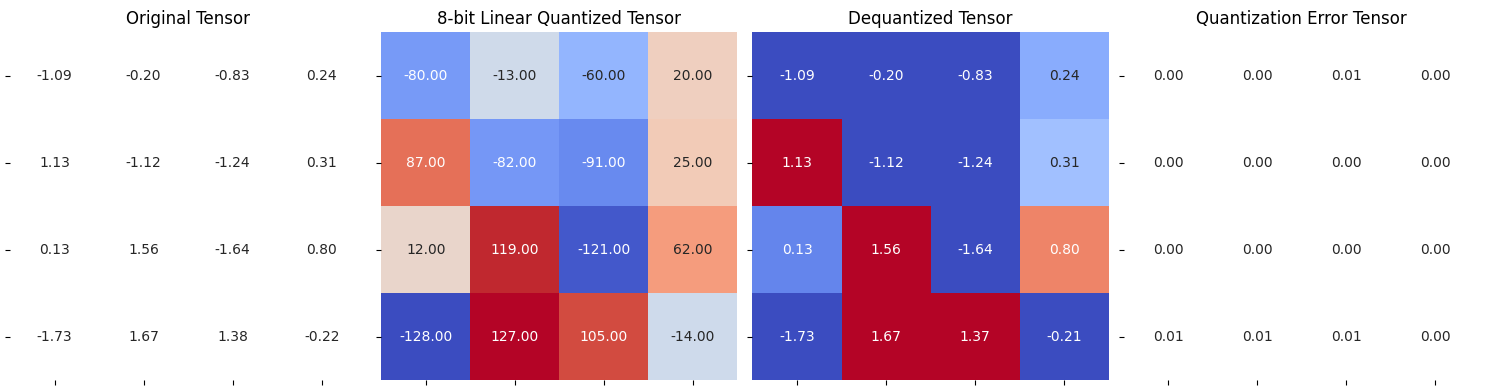

In [34]:
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

In [35]:
(dequantized_tensor - r_tensor).square().mean()

tensor(1.4534e-05)

# L3-A - Linear Quantization II: Symmetric vs. Asymmetric Mode

## Linear Quantization: Symmetric Mode
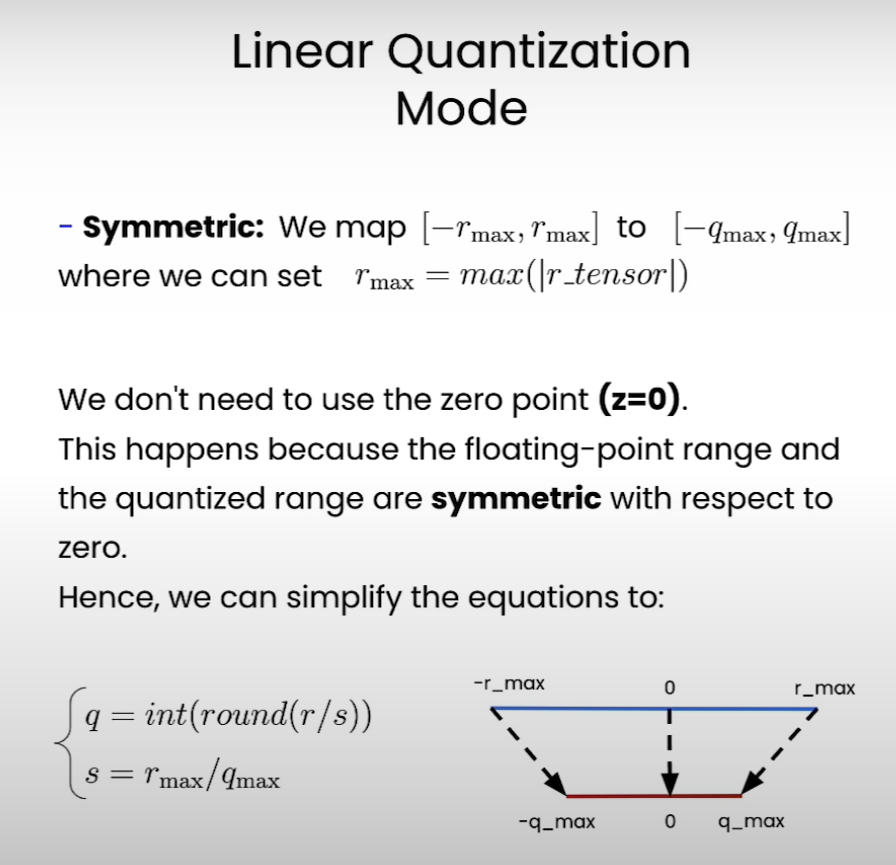
- Implement a function which returns the `scale` for Linear Quantization in Symmetric Mode.

In [36]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max

In [38]:
test_tensor = torch.randn((4,4))
test_tensor

tensor([[-0.7363,  0.5982, -2.2014, -0.4506],
        [ 0.1199, -1.0893,  0.2222, -0.6763],
        [ 0.5170, -1.3696, -0.2330,  1.9966],
        [ 0.3398, -0.5467, -2.3331, -0.1112]])

In [39]:
get_q_scale_symmetric(test_tensor)

0.018371210323544

- Perform Linear Quantization in Symmetric Mode.


In [40]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point=0)

    return quantized_tensor, scale

In [41]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

### Dequantization

- Perform Dequantization
- Plot the Quantization error.
- `linear_dequantization` is the same function you implemented in the previous lesson.

In [42]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

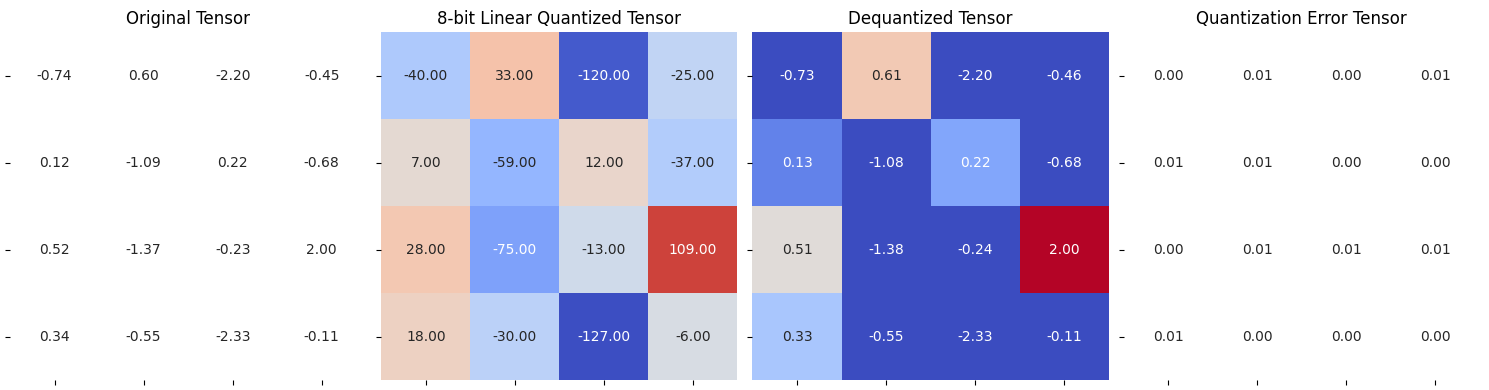

In [43]:
plot_quantization_errors(test_tensor,  quantized_tensor, dequantized_tensor)

In [45]:
print(f"Quantization error: {(test_tensor - dequantized_tensor).square().mean()}")

Quantization error: 3.2442509109387174e-05


### Linear Quantization Mode

Trade Off:
- Utilization of quantized range:
    - When using asymmetric quantization, the quantized range is fully utilized.
    - When symmetric mode, if the float range is biased towards one side, this will result in a quantized range where part of the range is dedicated to the values that we'll never see. (e.g ReLU where the output is positive)
- Simplicity: Symmetric mode is much simpler compare to asymmetric.
- Memory: We don't store zero-point for symmetric quantization

In practice we use symmetric quantization for 8 bit, but asymmetric for low precision such as 2, 3, or 4 bit.

# L3-B - Linear Quantization II: Finer Granularity for more Precision

In this lesson, you will learn about different granularities of performing linear quantization.
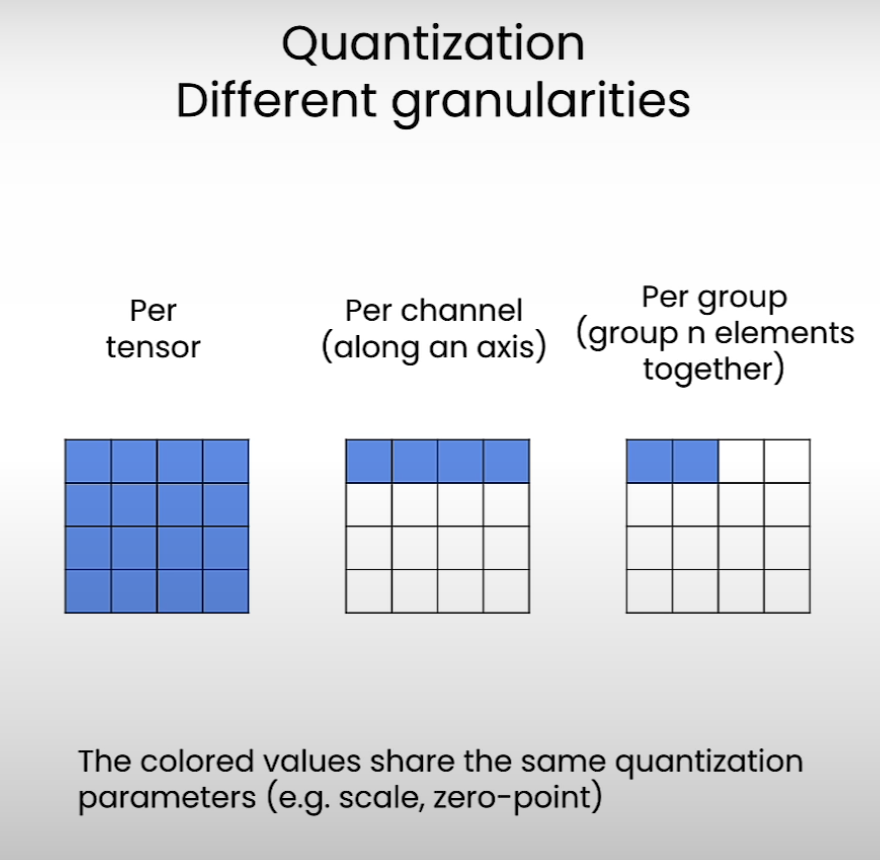

### Per Tensor
- Perform `Per Tensor` Symmetric Quantization.

In [46]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [47]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [48]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

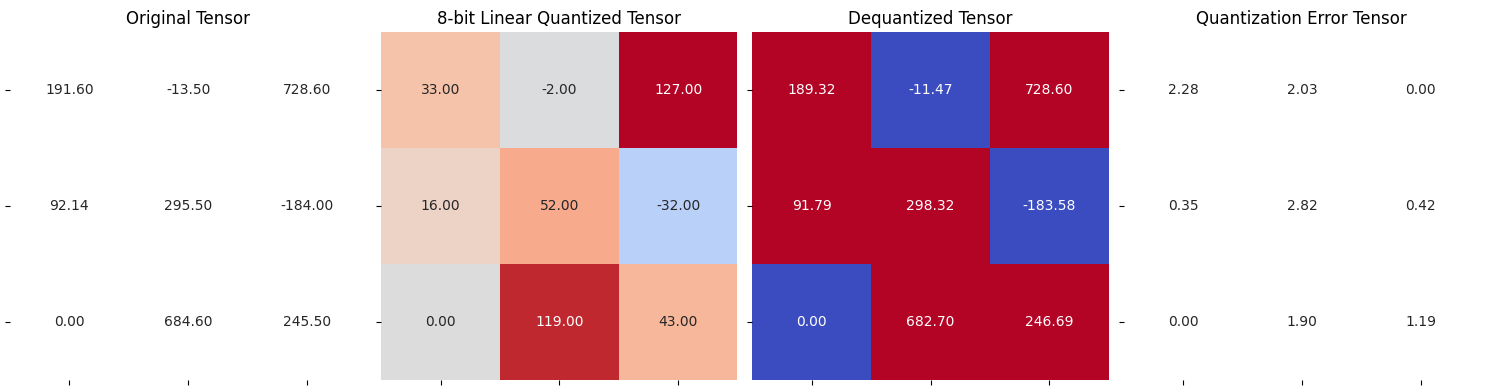

In [49]:
plot_quantization_errors(test_tensor, quantized_tensor,dequantized_tensor)

In [50]:
def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()

In [ ]:
print(f"Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}")

Quantization Error : 2.5091912746429443


# L3-C - Linear Quantization II: Per Channel Quantization

In this lesson, you will continue to learn about different granularities of performing linear quantization. You will cover `per channel`

### Per Channel
- Implement `Per Channel` Symmetric Quantization
- `dim` parameter decides if it needs to be along the rows or columns

In [52]:
def linear_q_symmetric_per_channel(tensor, dim, dtype=torch.int8):

    return quantized_tensor, scale

In [53]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

- `dim = 0`, along the rows
- `dim = 1`, along the columns

In [54]:
dim = 0
output_dim = test_tensor.shape[dim]
output_dim

3

In [75]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

- Iterate through each row to calculate its `scale`.

In [76]:
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim, index)
    # print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

scale

tensor([5.7370, 2.3268, 5.3906])

In [77]:
scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [79]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [80]:
scale = scale.view(scale_shape)
copy_scale = scale
scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

#### Understanding tensor by tensor division using `view` function

In [62]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [63]:
s = torch.tensor([1,5,10])
s

tensor([ 1,  5, 10])

In [64]:
s.shape

torch.Size([3])

In [69]:
a = s.view(1, 3)
a, a.shape

(tensor([[ 1,  5, 10]]), torch.Size([1, 3]))

In [71]:
# alternate way
s.view(1, -1).shape, s.view(-1,1).shape

(torch.Size([1, 3]), torch.Size([3, 1]))

##### Along the row division

In [72]:
scale = torch.tensor([[1], [5], [10]])
m/scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

##### Along the column division

In [73]:
scale = torch.tensor([[1, 5, 10]])
m/scale

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

#### Coming back to quantizing the tensor

In [81]:
scale = copy_scale
scale.shape

torch.Size([3, 1])

In [83]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

- Now, put all this in `linear_q_symmetric_per_channel` function defined earlier.

In [86]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)
    
    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(r_tensor, scale=scale, zero_point=0, dtype=dtype)

    return quantized_tensor, scale



In [87]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [88]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)

- Plot the quantization error for along the rows.

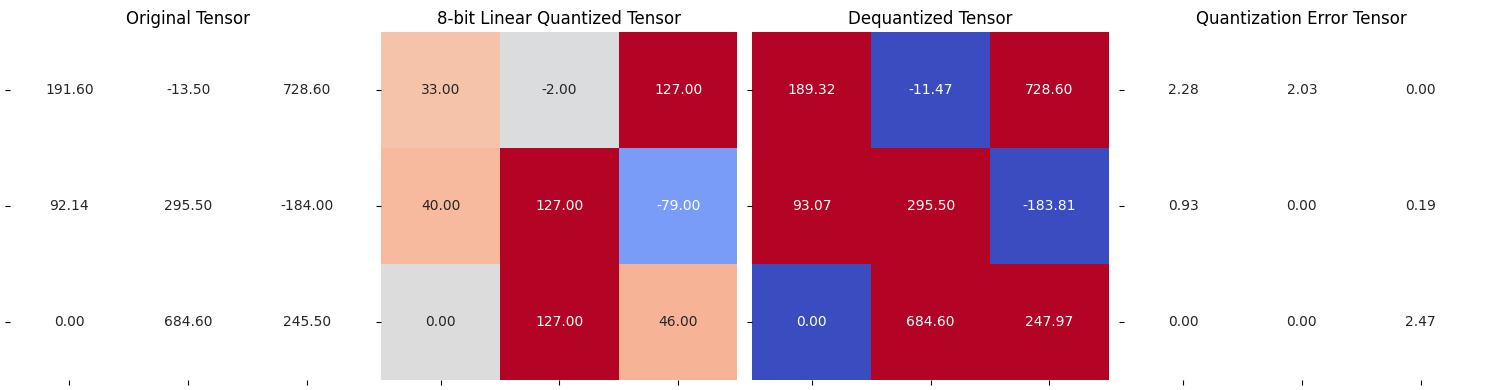

In [89]:
dequantized_tensor_0 = linear_dequantization(quantized_tensor_0, scale_0, 0)

plot_quantization_errors(test_tensor, quantized_tensor_0, dequantized_tensor_0)

In [90]:
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor_0)}""")

Quantization Error : 1.8084441423416138


- Plot the quantization error for along the columns.

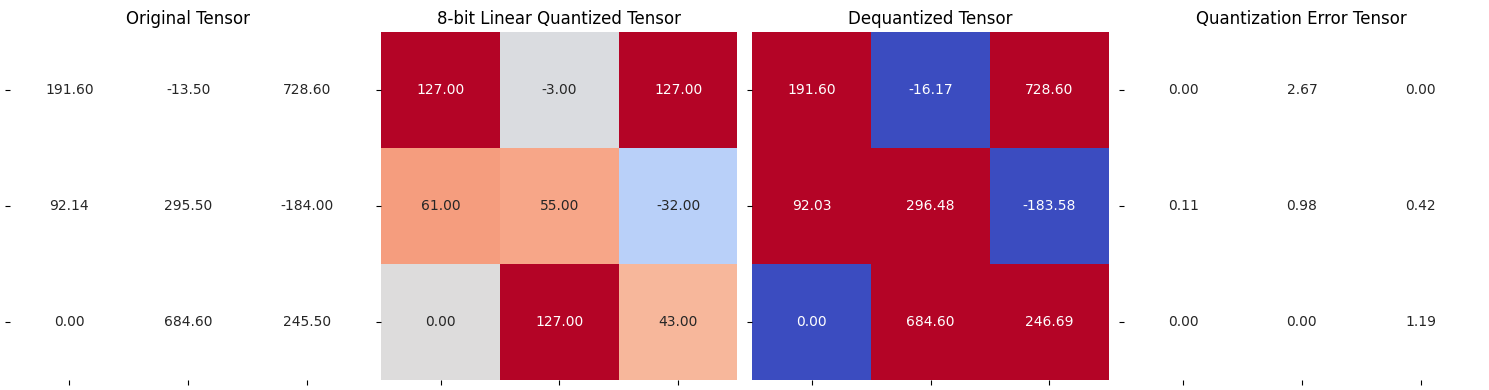

Quantization Error : 1.0781488418579102


In [91]:
dequantized_tensor_1 = linear_dequantization(
    quantized_tensor_1, scale_1, 0)

plot_quantization_errors(
    test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

# L3-D - Linear Quantization II: Per Group Quantization

### Per Group
- For simplicity, you'll quantize a 2D tensor along the rows.

In [92]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2

    tensor = tensor.view(-1, group_size)

    quantized_tensor, scale = linear_q_symmetric_per_channel(tensor, dim=0, dtype=dtype)
    quantized_tensor = quantized_tensor.view(t_shape)
    return quantized_tensor, scale


In [93]:
def linear_dequantization_per_group(quantization_tensor, scale, group_size):
    q_shape = quantization_tensor.shape
    quantization_tensor = quantization_tensor.view(-1, group_size)
    dequantized_tensor = linear_dequantization(quantization_tensor, scale, 0)
    dequantized_tensor = dequantized_tensor.view(q_shape)
    return dequantized_tensor

In [112]:
test_tensor = torch.rand((6, 6))

In [113]:
group_size = 3

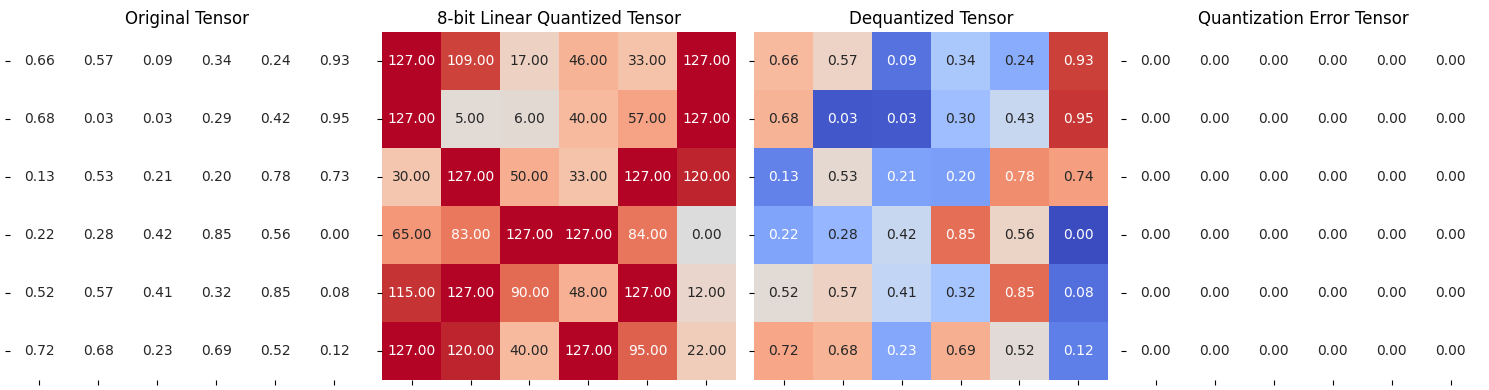

In [114]:
quantized_tensor, scale = linear_q_symmetric_per_group(test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [115]:
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.4386270069953753e-06
